# RGI-07: Region 06 (Iceland)
##### F. Maussion & S. Galos, July 2021

In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from utils import mkdir

## Files and storage paths

In [8]:
# Region of interest
reg = 6

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '06_rgi60_Iceland.zip')

In [9]:
# Specific to this region: RGI is made up by a series of spatially overlapping datasets
# selection of subsets is based on boxes which define areas for respective subset selection

support_dir = os.path.join(data_dir, 'l0_support_data')
box_file = os.path.join(support_dir, 'Iceland.tar.gz')

### Load the input data

In [10]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

## Apply selection criteria to create the RGI7 data subset

### Extract RGI6 from GLIMS data and do a check

In this special case RGI06 was made up from several files. Submission id 719 was added to GLIMS to document applied changes in glacier devides for RGI6 so data set serves as the baseline, we then add those parts of other submissions which are not covered by subm_id 719. To extract those we apply an overlay of representative points of each file and the polygons of subm_id 719.   

In [11]:
# define subsets according to submission id
sub_719 = shp.loc[shp['subm_id']==719]
sub_437 = shp.loc[shp['subm_id']==437]
sub_438 = shp.loc[shp['subm_id']==438]
sub_439 = shp.loc[shp['subm_id']==439]
sub_452 = shp.loc[shp['subm_id']==452]

### Extract relevant subset of each submission based on overlay with manually defined boxes

In [16]:
# load shapes
AOI_437 = gpd.read_file('tar://' + box_file + '/Iceland/AOI_437.shp')
AOI_438 = gpd.read_file('tar://' + box_file + '/Iceland/AOI_438.shp')
AOI_439 = gpd.read_file('tar://' + box_file + '/Iceland/AOI_439.shp')
AOI_452 = gpd.read_file('tar://' + box_file + '/Iceland/AOI_452.shp')

In [17]:
## extract relevant subsets by overlay

# 437
sub437_ss = gpd.overlay(sub_437, AOI_437, how='intersection')

# 438
sub438_ss = gpd.overlay(sub_438, AOI_438, how='intersection')

# 439
sub439_ss = gpd.overlay(sub_439, AOI_439, how='intersection')

# 452
sub452_ss = gpd.overlay(sub_452, AOI_452, how='intersection')

In [18]:
# append to subm 719 in order to create RGI regional subset
RGI_ss = sub_719.append([sub437_ss, sub438_ss, sub439_ss, sub452_ss], sort=True)

#### load reference data (here RGI6) to enable comparison

In [19]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

#### Number of elements (differences do not necessarily depict major problems)

In [20]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 567
Number of glaciers in reference data: 568
Difference: -1


#### check for dublicate glacier IDs

In [21]:
print ('number of glaciers without unique id in RGI06:', len(ref_odf)-len(ref_odf['GLIMSId'].unique()))

number of glaciers without unique id in RGI06: 0


In [22]:
print ('number of glaciers without unique id in RGI06 from GLIMS data base:', len(RGI_ss)-len(RGI_ss['glac_id'].unique()))

number of glaciers without unique id in RGI06 from GLIMS data base: 2


In [27]:
# check for dublicated glac_ids 
dub = RGI_ss[RGI_ss['glac_id'].duplicated()]
dub['glac_id']

1     G344437E64800N
15    G345728E64968N
Name: glac_id, dtype: object

'G344437E64800N'

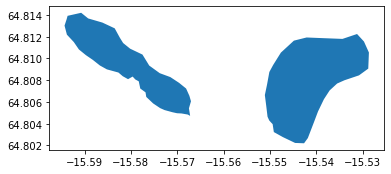

In [31]:
RGI_ss.loc[RGI_ss.glac_id == dub['glac_id'].iloc[0]].plot();

#### Check for 'nominal glaciers' in the RGI6 original data and delete them from new RGI subset from GLIMS if they are in there 

In [32]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2]
len(nom)

0

#### Total area

In [33]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area
nom['area'] = nom.to_crs({'proj':'cea'}).area

In [34]:
# print and compare area values
Area_RGI = RGI_ss['area'].sum()/1000000
print('Area RGI [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum()/1000000
print('Area Ref [km²]:', Area_ref)
Area_nom = nom['area'].sum()/1000000
print('Area Nom [km²]:', Area_nom)
d = (Area_RGI + Area_nom - Area_ref)*1000000
print('Area difference:',d, 'm²')

Area RGI [km²]: 11059.703473376434
Area Ref [km²]: 11059.70349144711
Area Nom [km²]: 0.0
Area difference: -18.070675650960766 m²


## Result of check (RGI from Glims global data base vs. RGI06 original):
#### the number of individual gaciers differs by 1 while areas of both files differ by only 18 m² for whole Region. Manual check in GIS did not show where the missing glacier has gone...
#### Dublicate glacier IDs: Two totally different glaciers have ID G345728E64968N, same is true for G344437E64800N.

## Write out and tar 

In [35]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))## Write out and tar 

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI06.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI06'], returncode=0)
